In [2]:
library(ggplot2)
library(dplyr)
library(pracma)
library(forecast)
library(tseries)
library(latex2exp)
library(nortsTest)
library(car)

# Funkcje

In [3]:
emp_ACVF <- function(X,h){
    n <- length(X)
    xm <- mean(X)
    X1 <- X[1:(n-abs(h))]
    X2 <- X[(1+abs(h)):n]
    return(1/n*sum((X1-xm)*(X2-xm)))
}

In [4]:
emp_acorr <- function(X,h){
    Z <- emp_ACVF(X,h)
    Y <- emp_ACVF(X,0)
    return(Z/Y)
}

# Wczytanie danych

In [109]:
denver_data <- read.csv('denver_data.csv')[,2:4]

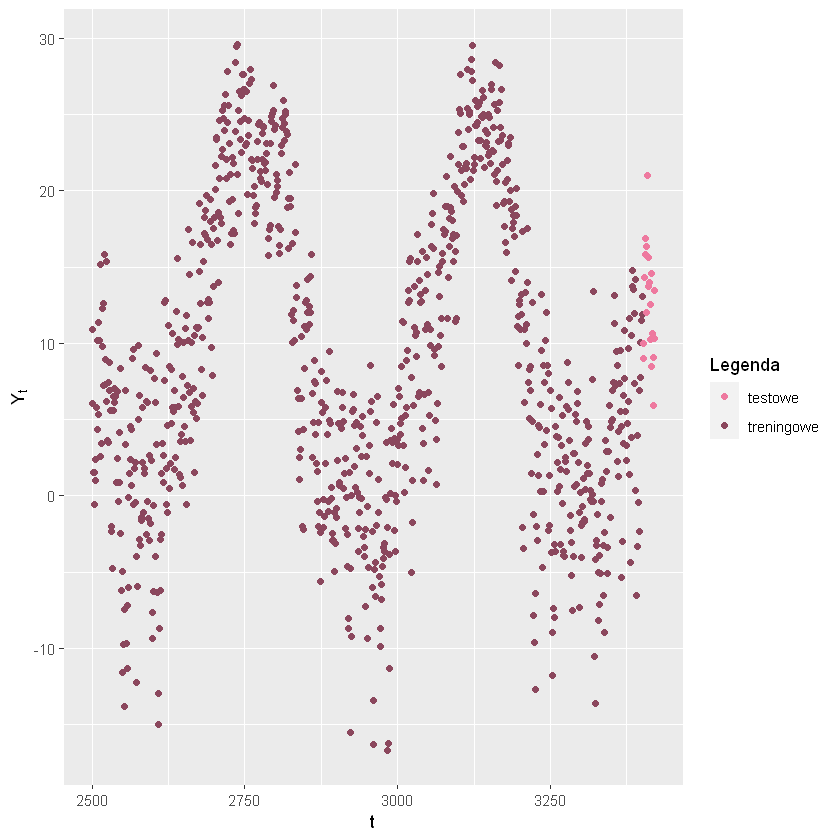

In [110]:
train_test_plot <- ggplot(denver_data[2500:3421,], aes(t,temp,col=type))+
    geom_point()+ylab(TeX('$Y_t$'))+
    scale_color_manual(values=c('palevioletred2','palevioletred4'))+
    guides(col=guide_legend(title="Legenda"))
train_test_plot
#ggsave('train_test.jpg', train_test_plot, 'jpg', width=10)

In [26]:
n <- length(denver_data$temp)
train_data <- denver_data$temp[1:(n-20)]
test_data <- denver_data$temp[(n-19):n]
df_train <- data.frame(1:length(train_data),train_data)
df_test <- data.frame((n-19):n,test_data)
colnames(df_test) <- c('t','temp')
colnames(df_train) <- c('t','temp')

In [27]:
df_test <- data.frame((n-19):n,test_data)
colnames(df_test) <- c('t','temp')

In [28]:
h <- 0:1000
corr_1 <- c()
for(i in h) corr_1[i+1] <- emp_acorr(df_train$temp,i)
df_h <- data.frame(h,corr_1)

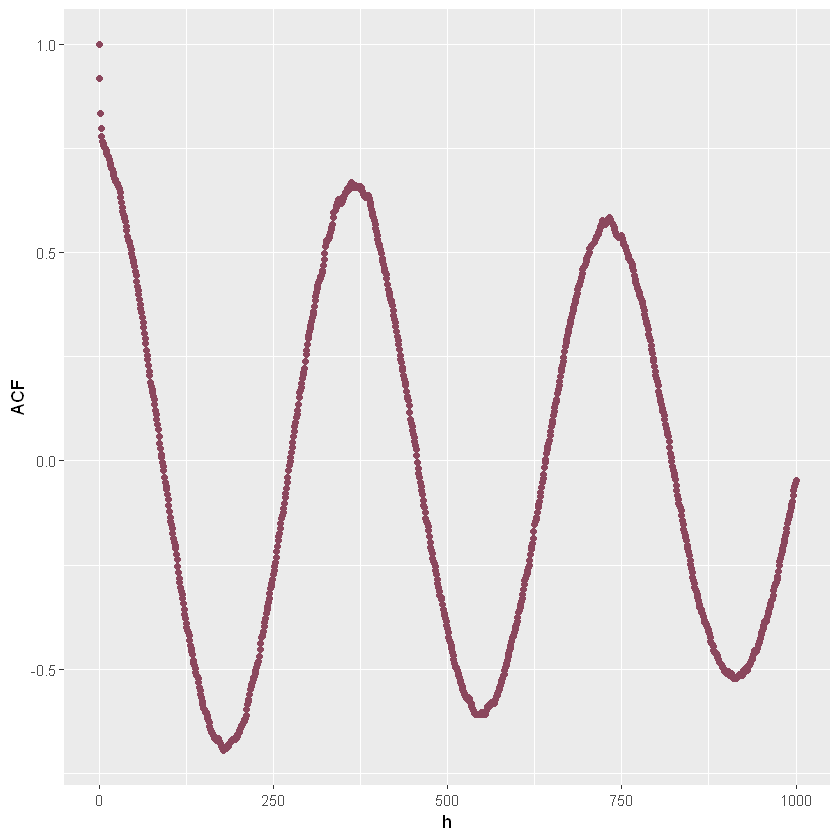

In [29]:
Yt_acf <- ggplot(df_h, aes(h,corr_1))+geom_point(col='palevioletred4')+ylab('ACF')
Yt_acf
#ggsave('yt_acf.jpg', Yt_acf, 'jpg', width=10)

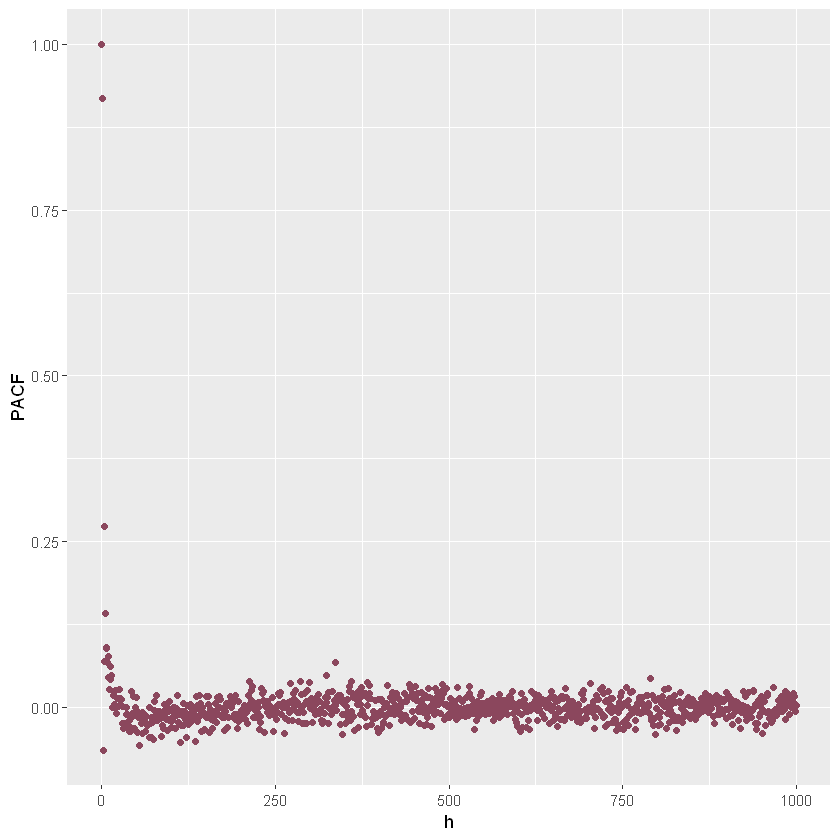

In [30]:
Yt_pacf <- ggplot(df_h, aes(h,c(1,pacf(df_train$temp,1000,plot=F)$acf)))+geom_point(col='palevioletred4')+ylab('PACF')
Yt_pacf
#ggsave('yt_pacf.jpg', Yt_pacf, 'jpg', width=10)

# Dekompozycja

## ADF test

In [31]:
adf.test(df_train$temp)$p.value

Warning message in adf.test(df_train$temp):
"p-value smaller than printed p-value"


[1] 0.01

## Trend

In [32]:
lm0 <- polyfit(df_train$t, df_train$temp, 0)
lm1 <- polyfit(df_train$t, df_train$temp, 1)
lm2 <- polyfit(df_train$t, df_train$temp, 2)
lm3 <- polyfit(df_train$t, df_train$temp, 3)
lm4 <- polyfit(df_train$t, df_train$temp, 4)
lm5 <- polyfit(df_train$t, df_train$temp, 5)

In [33]:
lm1_approx <- polyval(lm1,df_train$t)
lm2_approx <- polyval(lm2,df_train$t)
lm3_approx <- polyval(lm3,df_train$t)
lm4_approx <- polyval(lm4,df_train$t)
lm0_approx <- polyval(lm0,df_train$t)

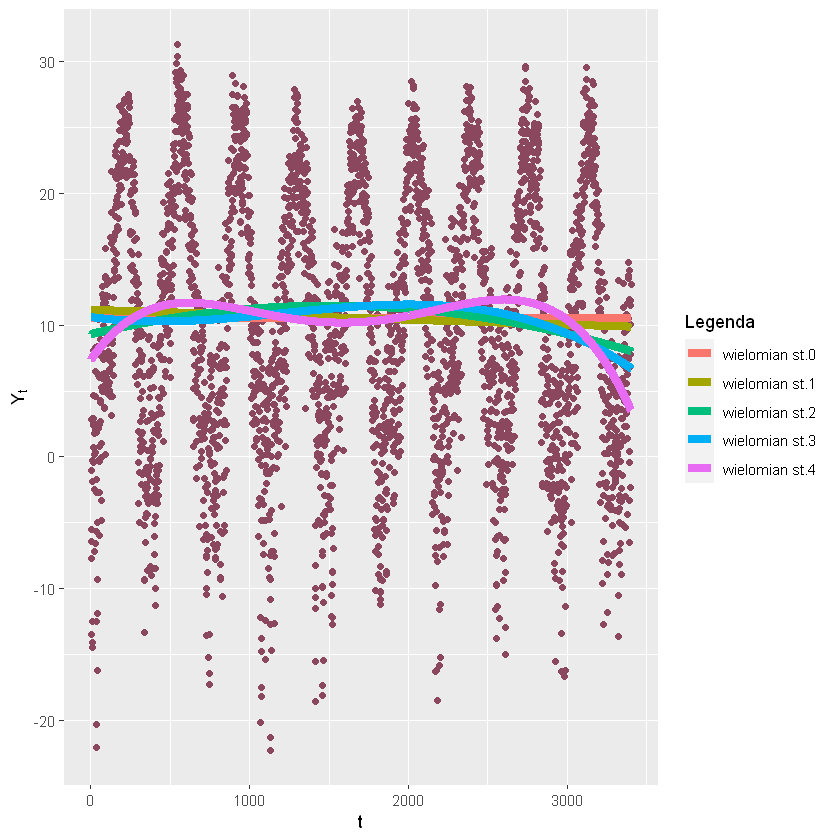

In [34]:
trend_fit <- ggplot(df_train, aes(t,temp))+geom_point(col='palevioletred4')+
    geom_line(aes(y=lm0_approx,col='wielomian st.0'),linewidth=2.5)+
    geom_line(aes(y=lm1_approx,col='wielomian st.1'),linewidth=2.5)+
    geom_line(aes(y=lm2_approx,col='wielomian st.2'),linewidth=2.5)+
    geom_line(aes(y=lm3_approx,col='wielomian st.3'),linewidth=2.5)+
    geom_line(aes(y=lm4_approx,col='wielomian st.4'),linewidth=2.5)+
    #scale_color_manual(values=c('palevioletred2','palevioletred4'))+
    guides(col=guide_legend(title="Legenda"))+ylab(TeX('$Y_t$'))
trend_fit
#ggsave('trend_fit.jpg', trend_fit, 'jpg', width=10)

In [35]:
df_train$temp_no_trend <- df_train$temp-lm0_approx

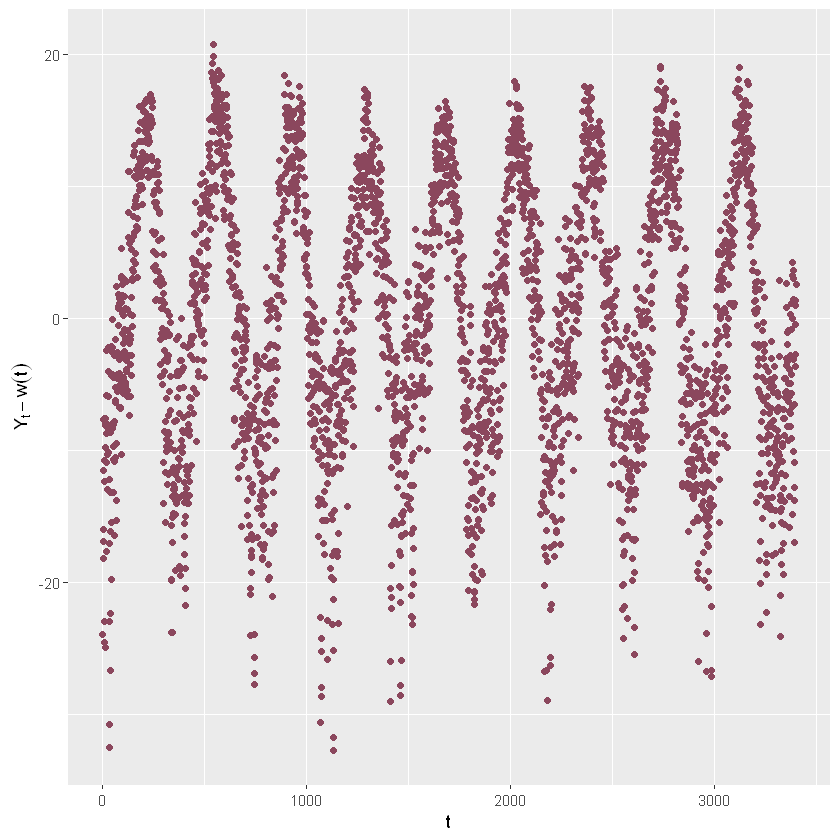

In [36]:
yt_no_trend <- ggplot(df_train, aes(t, temp_no_trend))+
    geom_point(col='palevioletred4')+ylab(TeX('$Y_t-w(t)$'))
yt_no_trend
#ggsave('yt_no_trend.jpg', yt_no_trend, 'jpg', width=10)

In [37]:
corr_2 <- c()
for(i in h) corr_2[i+1] <- emp_acorr(df_train$temp_no_trend,i)
df_h$corr2 <- corr_2

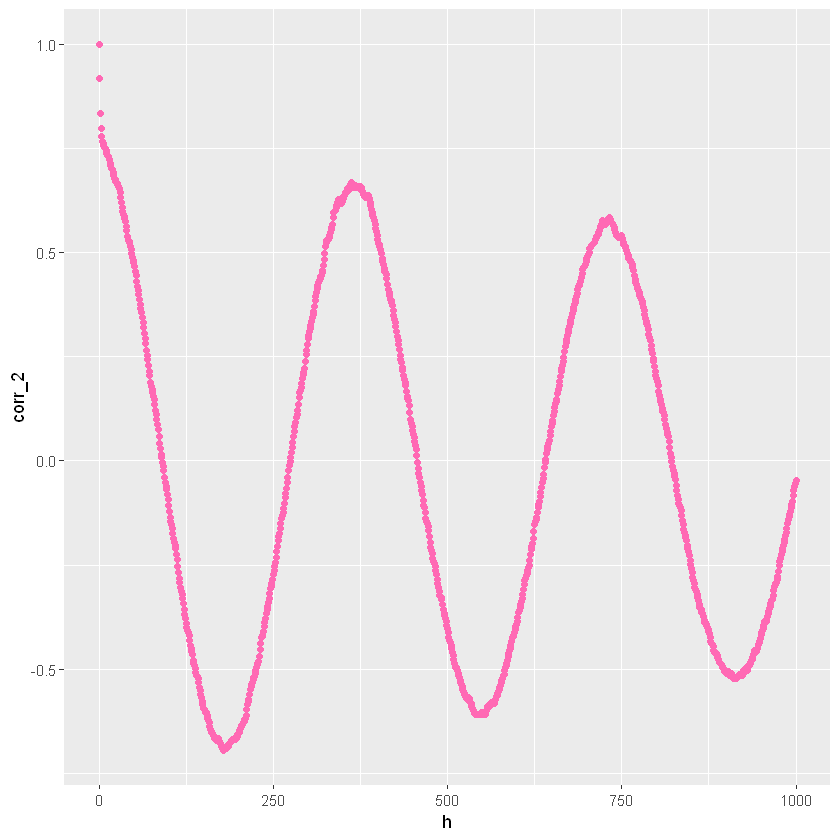

In [38]:
ggplot(df_h, aes(h,corr_2))+geom_point(col='hotpink')

## Sezonowość

In [39]:
period <- 365

In [40]:
vals_period <- vector()
for(i in 1:period){
    o <- vector()
    for(j in 0:floor(length(df_train$temp_no_trend)/period)-1) o[j+1] <- df_train$temp_no_trend[i+period*j]
    vals_period[i] <- mean(o)
}

In [41]:
s_almost <- rep(vals_period,10)[1:length(df_train$temp_no_trend)]
df_train$temp_no_season <- df_train$temp_no_trend-s_almost

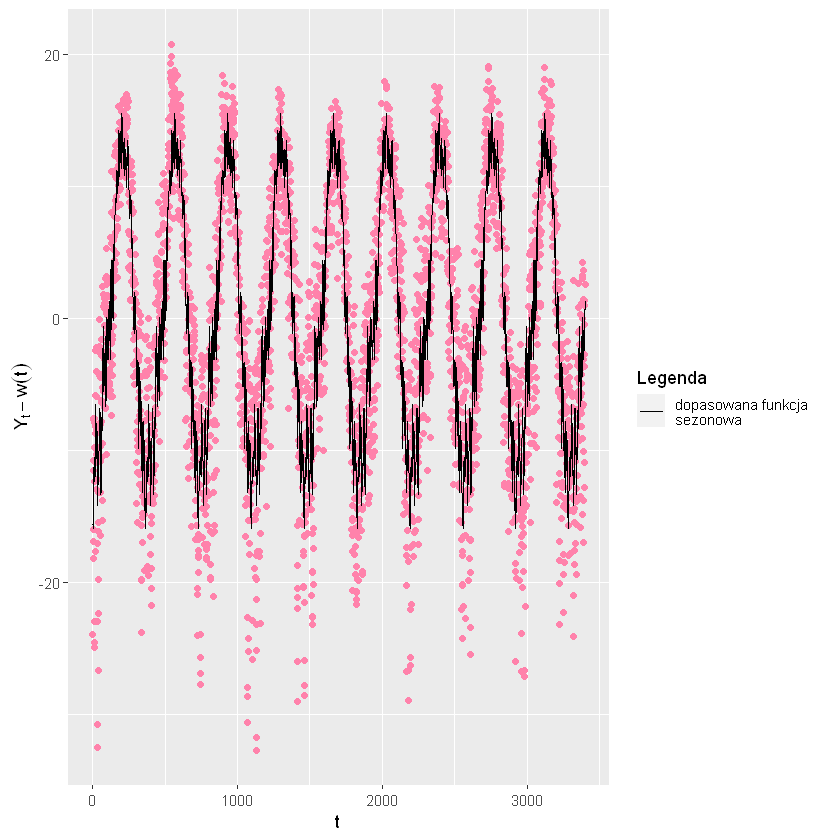

In [43]:
season_fit <- ggplot(df_train, aes(t, temp_no_trend))+
    geom_point(col='palevioletred1')+
    geom_line(aes(y=s_almost, col='dopasowana funkcja \nsezonowa'))+
    scale_color_manual(values=c('black'))+ylab(TeX('$Y_t-w(t)$'))+
    guides(col=guide_legend(title="Legenda"))
season_fit
#ggsave('season_fit.jpg', season_fit, 'jpg', width=10)

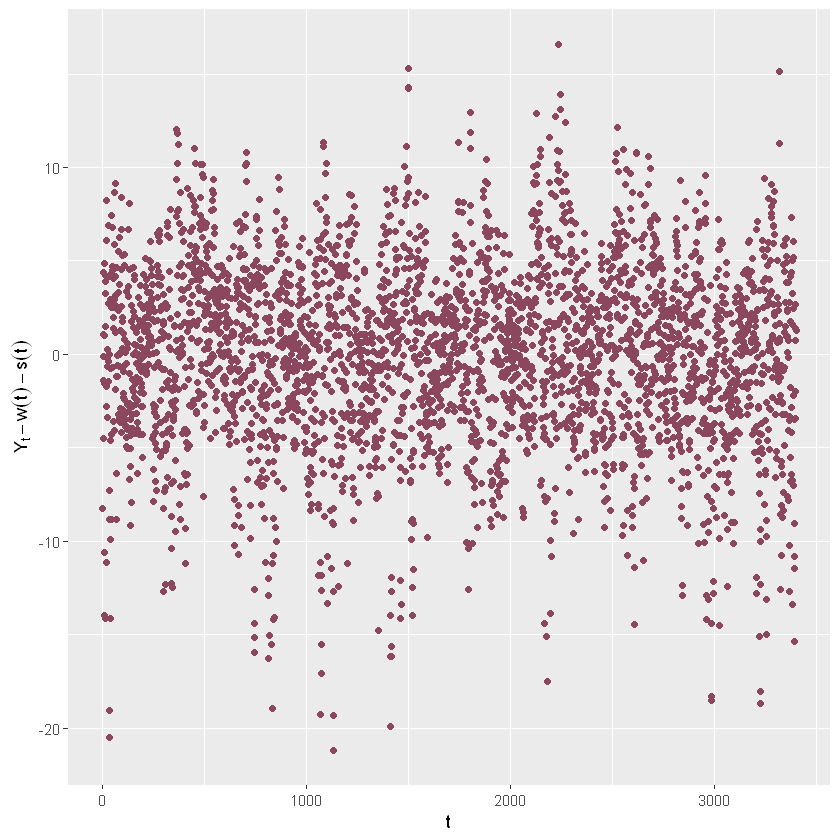

In [45]:
yt_no_season <- ggplot(df_train, aes(t, temp_no_season))+
    geom_point(col='palevioletred4')+
    ylab(TeX('$Y_t-w(t)-s(t)$'))
yt_no_season
#ggsave('yt_no_season.jpg', yt_no_season, 'jpg', width=10)

In [46]:
corr_3 <- c()
for(i in h) corr_3[i+1] <- emp_acorr(df_train$temp_no_season,i)
df_h$corr_3 <- corr_3

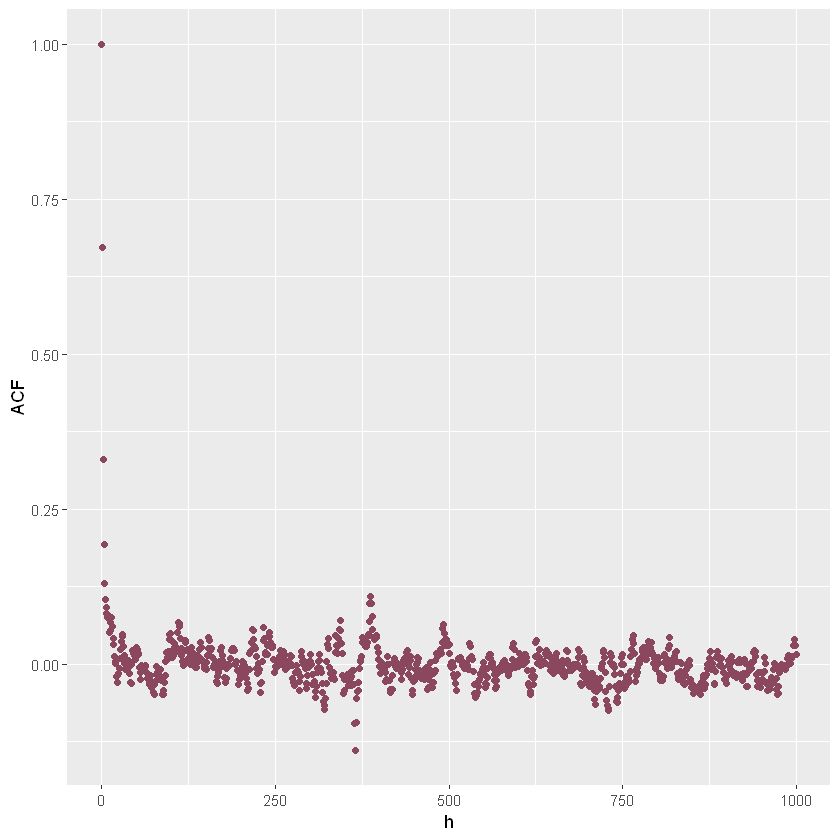

In [47]:
yt_no_season_acf <- ggplot(df_h, aes(h,corr_3))+geom_point(col='palevioletred4')+ylab('ACF')
yt_no_season_acf
#ggsave('yt_no_season_acf.jpg', yt_no_season_acf, 'jpg', width=10)

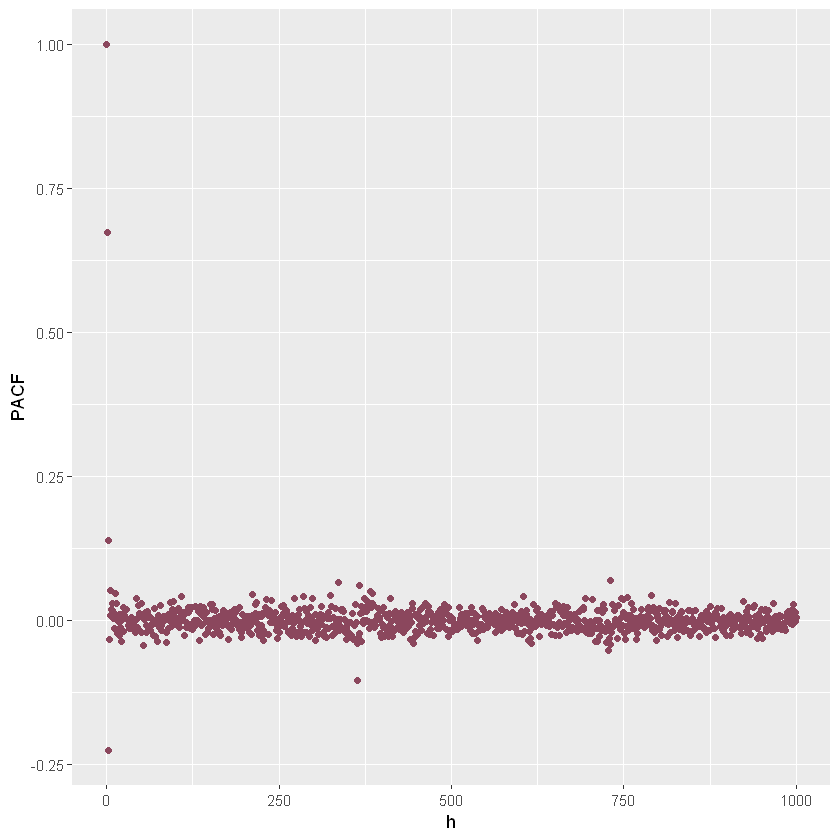

In [48]:
yt_no_season_pacf <- ggplot(df_h, aes(h,c(1,pacf(df_train$temp_no_season,1000,plot=F)$acf)))+geom_point(col='palevioletred4')+ylab('PACF')
yt_no_season_pacf
#ggsave('yt_no_season_pacf.jpg', yt_no_season_pacf, 'jpg', width=10)

In [51]:
findfrequency(df_train$temp_no_season)

[1] 1

## ADF test

In [52]:
adf.test(df_train$temp_no_season)$p.value

Warning message in adf.test(df_train$temp_no_season):
"p-value smaller than printed p-value"


[1] 0.01

# Modelowanie danych przy pomocy ARMA

## Dobieranie rzędu modelu (CI)

In [53]:
p <- c()
q <- c()
bic_vals <- c()
k <- 1
for(i in 1:10){
    for(j in 1:10){
        model <- arima(df_train$temp_no_season,order=c(i,0,j))
        bic_vals[k] <- BIC(model)
        p[k] <- i
        q[k] <- j
        k <- k+1
    }
}

Warning message in arima(df_train$temp_no_season, order = c(i, 0, j)):
"prawdopodobny problem zbieżności: 'optim' zwrócił kod= 1"
Warning message in arima(df_train$temp_no_season, order = c(i, 0, j)):
"prawdopodobny problem zbieżności: 'optim' zwrócił kod= 1"
Warning message in arima(df_train$temp_no_season, order = c(i, 0, j)):
"prawdopodobny problem zbieżności: 'optim' zwrócił kod= 1"
Warning message in arima(df_train$temp_no_season, order = c(i, 0, j)):
"prawdopodobny problem zbieżności: 'optim' zwrócił kod= 1"
Warning message in arima(df_train$temp_no_season, order = c(i, 0, j)):
"prawdopodobny problem zbieżności: 'optim' zwrócił kod= 1"
Warning message in arima(df_train$temp_no_season, order = c(i, 0, j)):
"prawdopodobny problem zbieżności: 'optim' zwrócił kod= 1"
Warning message in arima(df_train$temp_no_season, order = c(i, 0, j)):
"prawdopodobny problem zbieżności: 'optim' zwrócił kod= 1"
Warning message in arima(df_train$temp_no_season, order = c(i, 0, j)):
"prawdopodobny prob

In [54]:
df_bic <- data.frame(p,q,bic_vals)

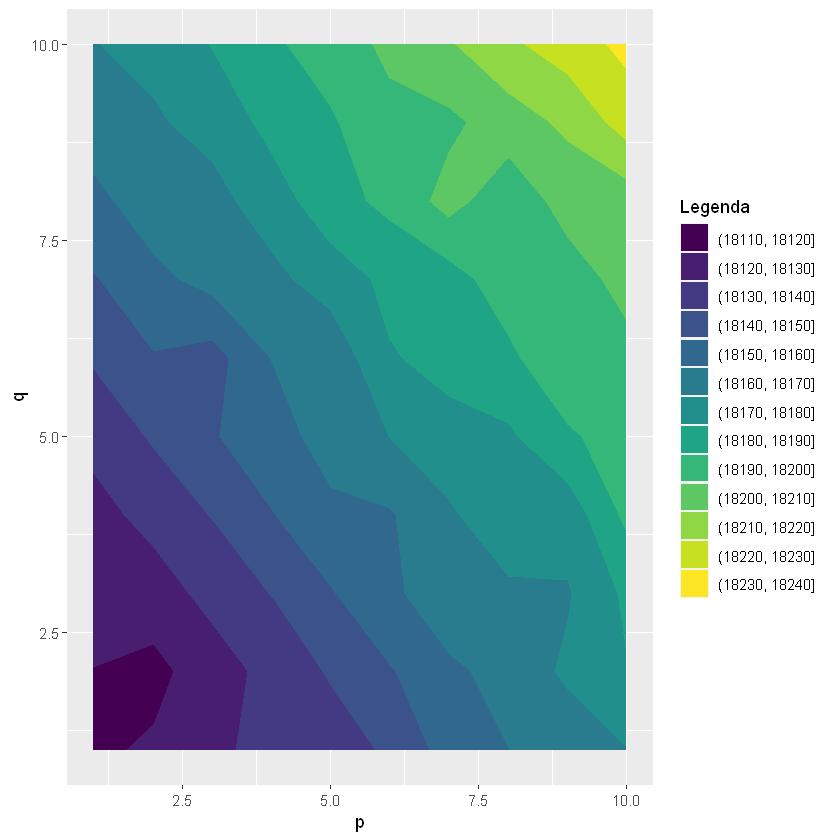

In [55]:
color_pal1 <- colorRampPalette(c('purple4','hotpink2','lightpink'))
bic_10 <- ggplot(df_bic, mapping=aes(p,q,z=bic_vals))+geom_contour_filled()+
    guides(fill=guide_legend(title="Legenda"))
bic_10
#ggsave('bic_10.jpg', bic_10, 'jpg', width=10)

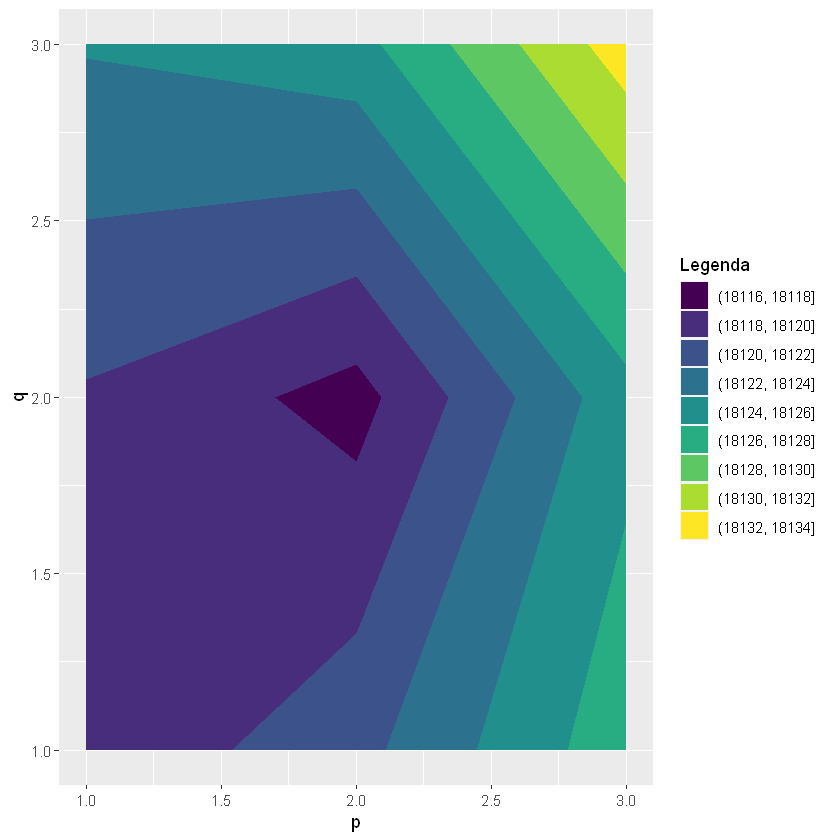

In [56]:
bic_3 <- ggplot(df_bic[df_bic$p<=3&df_bic$q<=3,], mapping=aes(p,q,z=bic_vals))+geom_contour_filled()+
    guides(fill=guide_legend(title="Legenda"))
bic_3
#ggsave('bic_3.jpg', bic_3, 'jpg', width=10)

In [57]:
p <- c()
q <- c()
aic_vals <- c()
k <- 1
for(i in 1:10){
    for(j in 1:10){
        model <- arima(df_train$temp_no_season,order=c(i,0,j))
        aic_vals[k] <- AIC(model)
        p[k] <- i
        q[k] <- j
        k <- k+1
    }
}

Warning message in arima(df_train$temp_no_season, order = c(i, 0, j)):
"prawdopodobny problem zbieżności: 'optim' zwrócił kod= 1"
Warning message in arima(df_train$temp_no_season, order = c(i, 0, j)):
"prawdopodobny problem zbieżności: 'optim' zwrócił kod= 1"
Warning message in arima(df_train$temp_no_season, order = c(i, 0, j)):
"prawdopodobny problem zbieżności: 'optim' zwrócił kod= 1"
Warning message in arima(df_train$temp_no_season, order = c(i, 0, j)):
"prawdopodobny problem zbieżności: 'optim' zwrócił kod= 1"
Warning message in arima(df_train$temp_no_season, order = c(i, 0, j)):
"prawdopodobny problem zbieżności: 'optim' zwrócił kod= 1"
Warning message in arima(df_train$temp_no_season, order = c(i, 0, j)):
"prawdopodobny problem zbieżności: 'optim' zwrócił kod= 1"
Warning message in arima(df_train$temp_no_season, order = c(i, 0, j)):
"prawdopodobny problem zbieżności: 'optim' zwrócił kod= 1"
Warning message in arima(df_train$temp_no_season, order = c(i, 0, j)):
"prawdopodobny prob

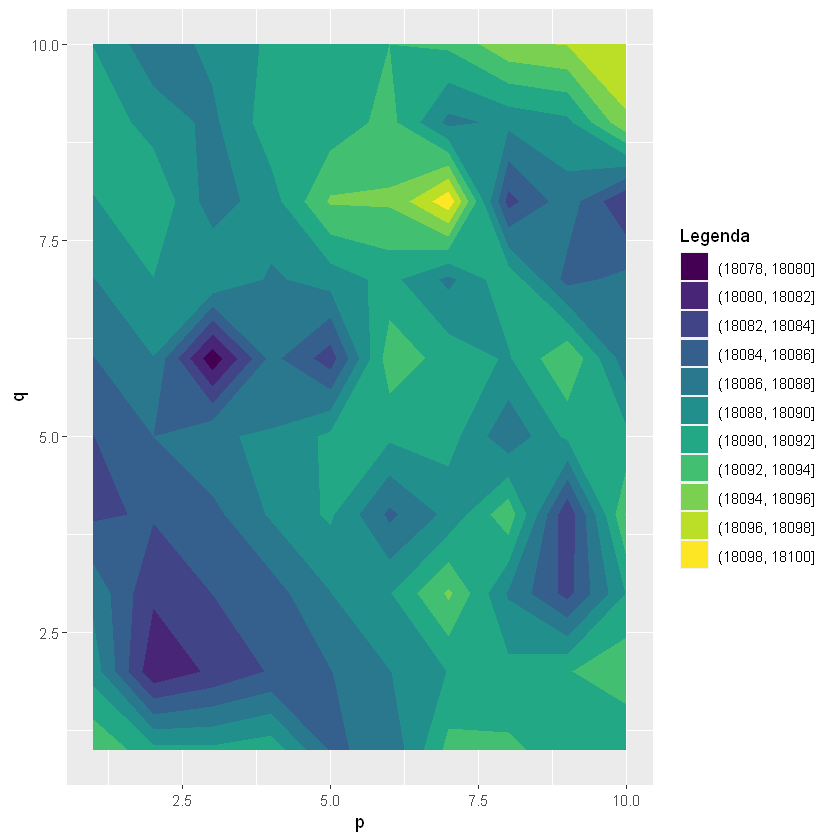

In [58]:
df_aic <- data.frame(p,q,aic_vals)
aic_10 <- ggplot(df_aic, mapping=aes(p,q,z=aic_vals))+geom_contour_filled()+
    guides(fill=guide_legend(title="Legenda"))
aic_10
#ggsave('aic_10.jpg', aic_10, 'jpg', width=10)

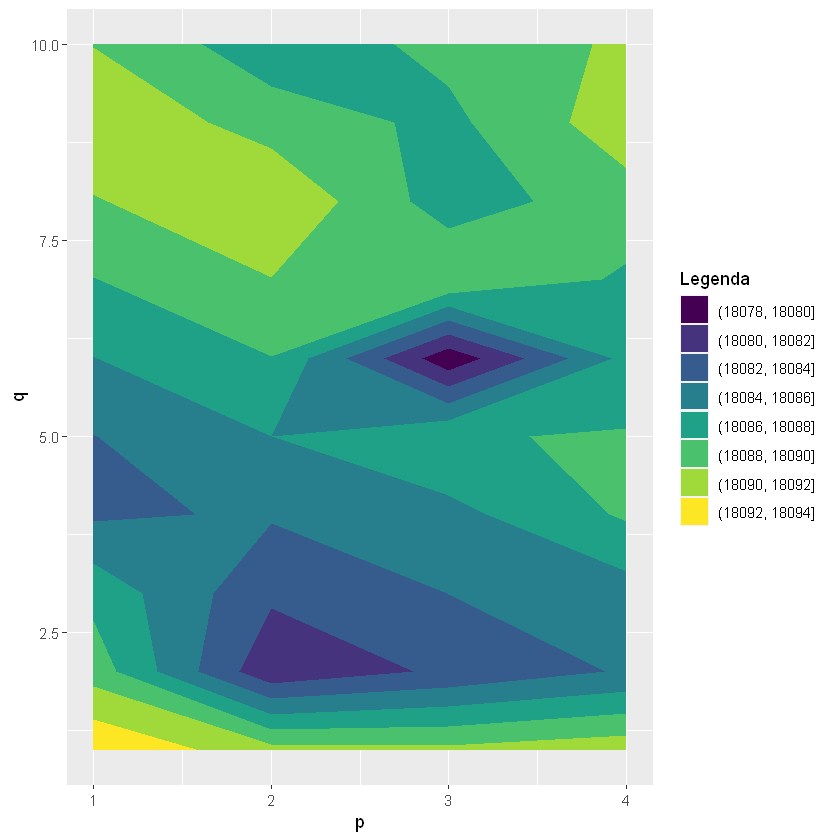

In [59]:
df_aic <- data.frame(p,q,aic_vals)
aic_3 <- ggplot(df_aic[df_aic$p<5,], mapping=aes(p,q,z=aic_vals))+geom_contour_filled()+
    guides(fill=guide_legend(title="Legenda"))
aic_3
#ggsave('aic_3.jpg', aic_3, 'jpg', width=10)

## ARMA(2,2)

## Estymacja parametrów ML

In [60]:
model <- arima(df_train$temp_no_season,order=c(2,0,2), method='ML')

In [61]:
model


Call:
arima(x = df_train$temp_no_season, order = c(2, 0, 2), method = "ML")

Coefficients:
        ar1      ar2      ma1      ma2  intercept
      1.279  -0.3365  -0.4173  -0.3864    -0.0333
s.e.  0.068   0.0437   0.0666   0.0271     0.2016

sigma^2 estimated as 11.88:  log likelihood = -9034.23,  aic = 18080.46

# Ocena dopasowania modelu

## Przedziały ufności

In [62]:
n <- 1001
X0 <- 0
X1 <- 0
pacf3 <- c()
h2 <- c()
phi1 <- model$coef[[1]]
phi2 <- model$coef[[2]]
theta1 <- model$coef[[3]]
theta2 <- model$coef[[4]]
sig <- sqrt(11.88)
corr_teor <- c()
h <- c()
k <- 1

for(i in 1:1000){
    Z <- rnorm(n+2,0,sig)
    X <- c(X0,X1)
    for(i in 1:(n-1)){
        X[i+2] <- phi1*X[i+1]+phi2*X[i]+Z[i+2]+theta1*Z[i+1]+theta2*Z[i]
    }
    temp <- pacf(X,1000,plot=F)
    pacf3 <- c(pacf3,temp$acf)
    h2 <- c(h2,temp$lag)
    for(j in 0:1000){
        corr_teor[k] <- emp_acorr(X,j)
        h[k] <- j
        k <- k+1
    }
}

In [63]:
pacf3 <- c(1,pacf3)
h2 <- c(0,h2)

In [64]:
df_corr_teor_left <- data.frame(h,corr_teor) %>% 
                         group_by(h) %>% 
                               summarise(corr_teor=quantile(corr_teor,0.05))
df_corr_teor_right <- data.frame(h,corr_teor) %>% 
                          group_by(h) %>% 
                                summarise(corr_teor=quantile(corr_teor,0.95))
                                 
df_pacf_left <- data.frame(h2,pacf3) %>% group_by(h2) %>% 
    summarise(pacf3=quantile(pacf3,0.05))
df_pacf_right <- data.frame(h2,pacf3) %>% group_by(h2) %>% 
    summarise(pacf3=quantile(pacf3,1-0.05))

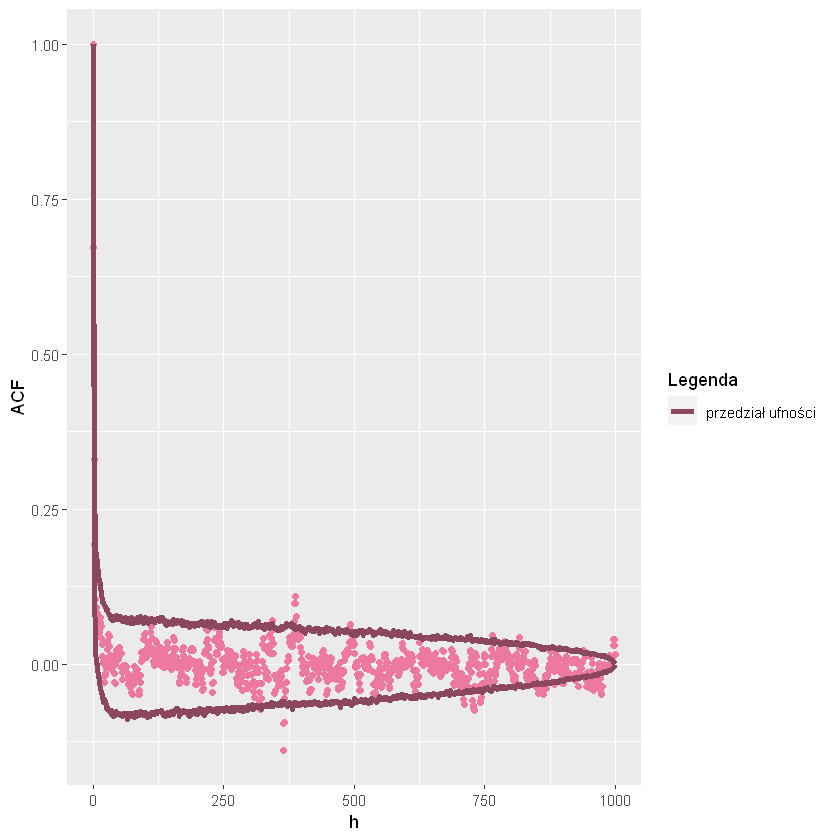

In [65]:
acf_fit <- ggplot(df_h, aes(h,corr_3))+geom_point(col='palevioletred2')+
    geom_line(aes(y=df_corr_teor_left$corr_teor, col='przedział ufności'),linewidth=1.5)+
    geom_line(aes(y=df_corr_teor_right$corr_teor, col='przedział ufności'),linewidth=1.5)+
    scale_color_manual(values=c('palevioletred4'))+ylab('ACF')+xlab('h')+
    guides(col=guide_legend(title="Legenda"))
acf_fit
#ggsave('acf_fit.jpg', acf_fit, 'jpg', width=10)

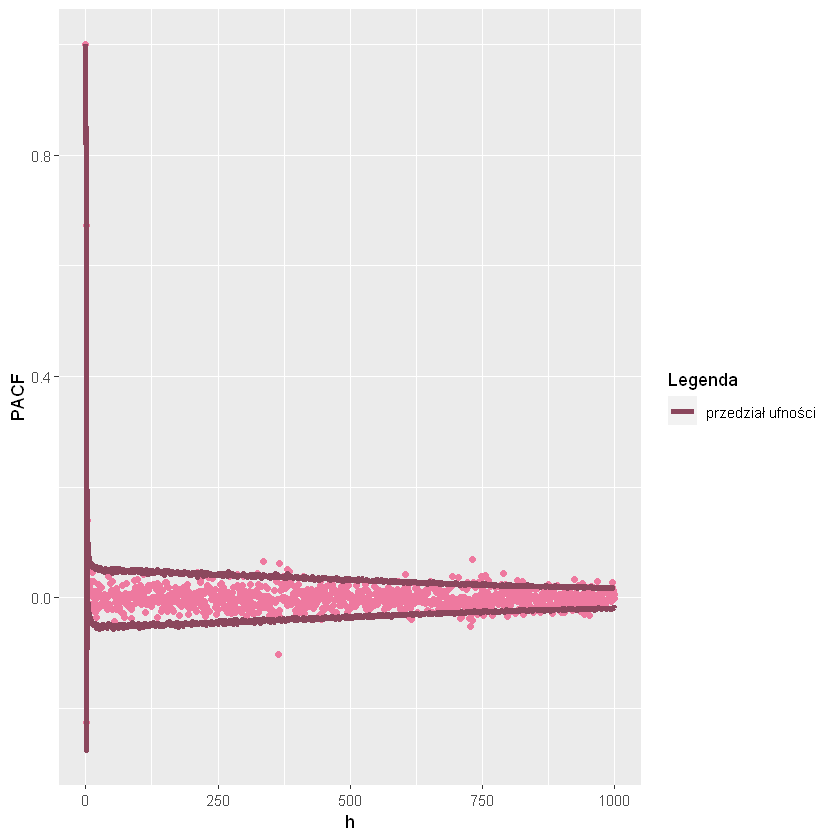

In [66]:
pacf_fit <- ggplot(mapping=aes(0:1000,c(1,pacf(df_train$temp_no_season,1000,plot=F)$acf)))+
    geom_point(col='palevioletred2')+
    geom_line(aes(y=df_pacf_left$pacf3, col='przedział ufności'),linewidth=1.5)+
    geom_line(aes(y=df_pacf_right$pacf3, col='przedział ufności'),linewidth=1.5)+
    scale_color_manual(values=c('palevioletred4'))+ylab('PACF')+xlab('h')+
    guides(col=guide_legend(title="Legenda"))
pacf_fit
#ggsave('pacf_fit.jpg', pacf_fit, 'jpg', width=10)

In [81]:
k <- forecast(df_train$temp_no_season,21)

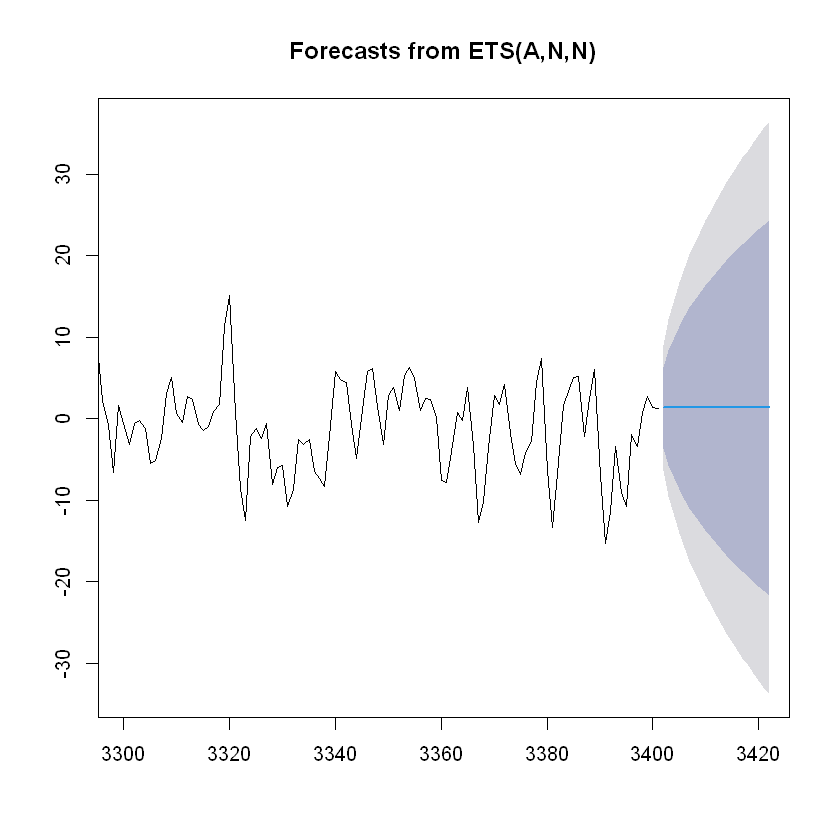

In [82]:
plot(k, xlim=c(3300,3421))

## Linie kwantylowe

In [83]:
trajectories <- matrix(0,nrow=1000, ncol=3421)
for(i in 1:1000){
    trajectories[i,] <- arima.sim(n=3421,list(ar=c(model$coef[[1]],model$coef[[2]]),
                          ma=c(model$coef[[3]],model$coef[[4]])),
              sd=sqrt(11.88))
}

In [84]:
quant_5 <- c()
for(i in 1:3401) quant_5[i] <- quantile(trajectories[,i],0.05)
quant_95 <- c()
for(i in 1:3401) quant_95[i] <- quantile(trajectories[,i],0.95)
quant_10 <- c()
for(i in 1:3401) quant_10[i] <- quantile(trajectories[,i],0.1)
quant_90 <- c()
for(i in 1:3401) quant_90[i] <- quantile(trajectories[,i],0.9)
quant_20 <- c()
for(i in 1:3401) quant_20[i] <- quantile(trajectories[,i],0.2)
quant_80 <- c()
for(i in 1:3401) quant_80[i] <- quantile(trajectories[,i],0.8)
quant_30 <- c()
for(i in 1:3401) quant_30[i] <- quantile(trajectories[,i],0.3)
quant_70 <- c()
for(i in 1:3401) quant_70[i] <- quantile(trajectories[,i],0.7)
quant_40 <- c()
for(i in 1:3401) quant_40[i] <- quantile(trajectories[,i],0.4)
quant_60 <- c()
for(i in 1:3401) quant_60[i] <- quantile(trajectories[,i],0.6)

In [85]:
season_vals <- rep(vals_period,10)[1:3401]
quant_5_good <- quant_5+season_vals+lm0
quant_95_good <- quant_95+season_vals+lm0
quant_10_good <- quant_10+season_vals+lm0
quant_90_good <- quant_90+season_vals+lm0
quant_20_good <- quant_20+season_vals+lm0
quant_80_good <- quant_80+season_vals+lm0
quant_30_good <- quant_30+season_vals+lm0
quant_70_good <- quant_70+season_vals+lm0
quant_40_good <- quant_40+season_vals+lm0
quant_60_good <- quant_60+season_vals+lm0

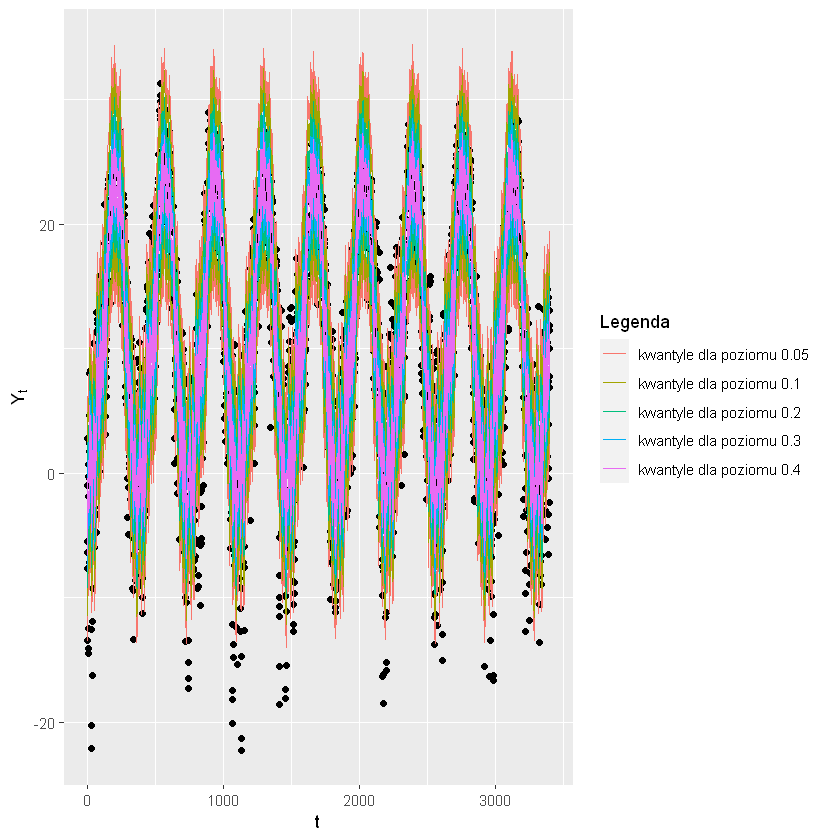

In [86]:
quantile_lines <- ggplot(df_train, aes(t,temp))+
    geom_point()+ylab(TeX('$Y_t$'))+
    geom_line(aes(y=quant_5_good,col='kwantyle dla poziomu 0.05'))+
    geom_line(aes(y=quant_95_good,col='kwantyle dla poziomu 0.05'))+
    geom_line(aes(y=quant_10_good,col='kwantyle dla poziomu 0.1'))+
    geom_line(aes(y=quant_90_good,col='kwantyle dla poziomu 0.1'))+
    geom_line(aes(y=quant_20_good,col='kwantyle dla poziomu 0.2'))+
    geom_line(aes(y=quant_80_good,col='kwantyle dla poziomu 0.2'))+
    geom_line(aes(y=quant_30_good,col='kwantyle dla poziomu 0.3'))+
    geom_line(aes(y=quant_70_good,col='kwantyle dla poziomu 0.3'))+
    geom_line(aes(y=quant_40_good,col='kwantyle dla poziomu 0.4'))+
    geom_line(aes(y=quant_60_good,col='kwantyle dla poziomu 0.4'))+
    #scale_color_manual(values=c('palevioletred2','palevioletred4'))+
    guides(col=guide_legend(title="Legenda"))
quantile_lines

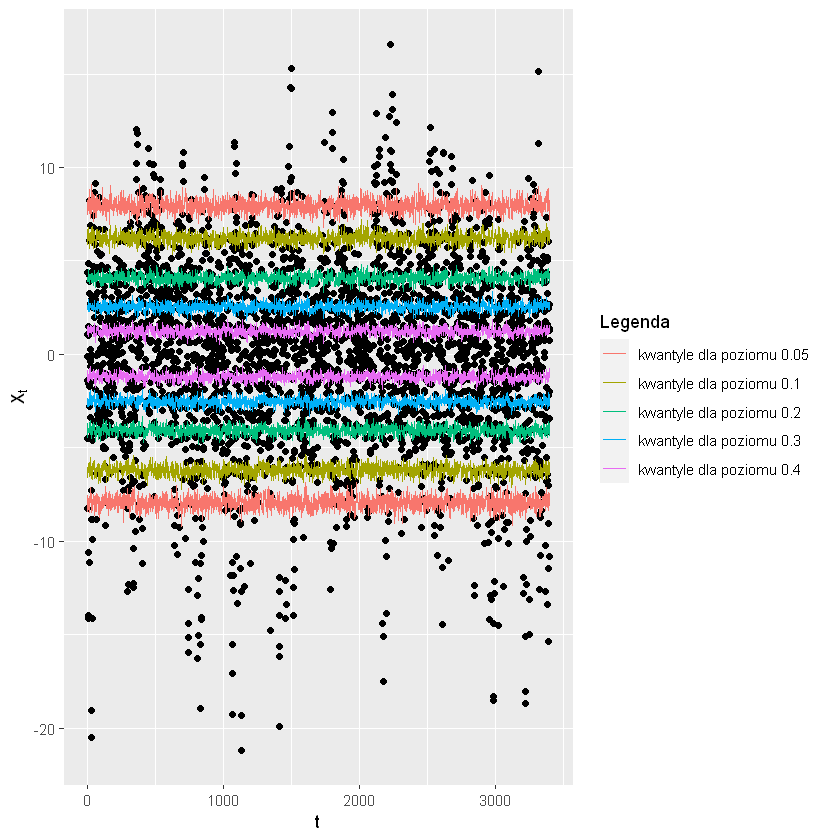

In [87]:
quantile_lines <- ggplot(df_train, aes(t,temp_no_season))+
    geom_point()+ylab(TeX('$X_t$'))+
    geom_line(aes(y=quant_5,col='kwantyle dla poziomu 0.05'))+
    geom_line(aes(y=quant_95,col='kwantyle dla poziomu 0.05'))+
    geom_line(aes(y=quant_10,col='kwantyle dla poziomu 0.1'))+
    geom_line(aes(y=quant_90,col='kwantyle dla poziomu 0.1'))+
    geom_line(aes(y=quant_20,col='kwantyle dla poziomu 0.2'))+
    geom_line(aes(y=quant_80,col='kwantyle dla poziomu 0.2'))+
    geom_line(aes(y=quant_30,col='kwantyle dla poziomu 0.3'))+
    geom_line(aes(y=quant_70,col='kwantyle dla poziomu 0.3'))+
    geom_line(aes(y=quant_40,col='kwantyle dla poziomu 0.4'))+
    geom_line(aes(y=quant_60,col='kwantyle dla poziomu 0.4'))+
    #scale_color_manual(values=c('palevioletred2','palevioletred4'))+
    guides(col=guide_legend(title="Legenda"))
quantile_lines
#ggsave('quantile_lines.jpg', quantile_lines, 'jpg', width=10)

In [88]:
prob5 <- 0
prob10 <- 0
prob20 <- 0
prob30 <- 0
prob40 <- 0
for(i in 1:3401){
    X <- df_train$temp_no_season[i]
    if(X>quant_5[i] & X<quant_95[i]) prob5 <- prob5+1
    if(X>quant_10[i] & X<quant_90[i]) prob10 <- prob10+1
    if(X>quant_20[i] & X<quant_80[i]) prob20 <- prob20+1
    if(X>quant_30[i] & X<quant_70[i]) prob30 <- prob30+1
    if(X>quant_40[i] & X<quant_60[i]) prob40 <- prob40+1
}

In [89]:
probs <- data.frame(prob5,prob10,prob20,prob30,prob40)
probs/3401

prob5,prob10,prob20,prob30,prob40
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.905616,0.8226992,0.6336372,0.4266392,0.2125845


## Prognoza

In [90]:
trajectories2 <- matrix(0,nrow=1000, ncol=20)
for(i in 1:1000){
    trajectories2[i,] <- arima.sim(n=3421,list(ar=c(model$coef[[1]],model$coef[[2]]),
                          ma=c(model$coef[[3]],model$coef[[4]])),
              sd=sqrt(11.88))[3402:3421]
}

In [91]:
quant_5_2 <- c()
for(i in 1:20) quant_5_2[i] <- quantile(trajectories2[,i],0.05)
quant_95_2 <- c()
for(i in 1:20) quant_95_2[i] <- quantile(trajectories2[,i],0.95)

In [92]:
season_vals2 <- rep(vals_period,10)[3402:3421]

In [93]:
quant_5_good_2 <- quant_5_2+season_vals2+lm0
quant_95_good_2 <- quant_95_2+season_vals2+lm0

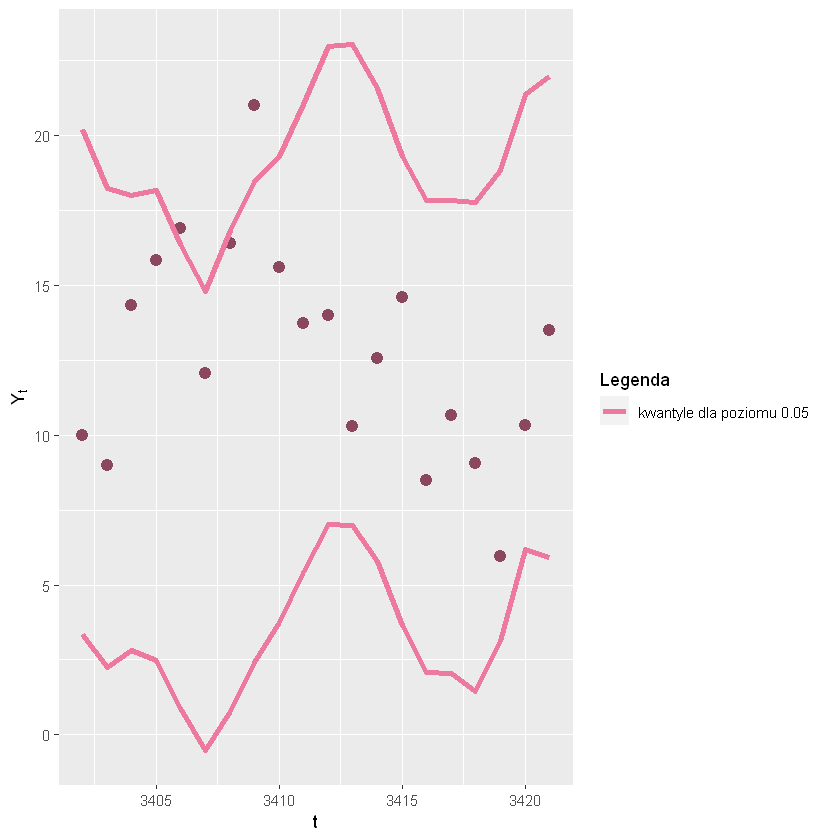

In [94]:
predict_lines <- ggplot(df_test, aes(t,temp))+
    geom_point(cex=3, col='palevioletred4')+ylab(TeX('$Y_t$'))+
    geom_line(aes(y=quant_5_good_2,col='kwantyle dla poziomu 0.05'),linewidth=1.5)+
    geom_line(aes(y=quant_95_good_2,col='kwantyle dla poziomu 0.05'),linewidth=1.5)+
    scale_color_manual(values=c('palevioletred2'))+
    guides(col=guide_legend(title="Legenda"))
predict_lines
#ggsave('predict_lines.jpg', predict_lines, 'jpg', width=10)

## Generowanie szumu

In [95]:
#write.csv(residuals(model),'residua.csv')

In [96]:
model


Call:
arima(x = df_train$temp_no_season, order = c(2, 0, 2), method = "ML")

Coefficients:
        ar1      ar2      ma1      ma2  intercept
      1.279  -0.3365  -0.4173  -0.3864    -0.0333
s.e.  0.068   0.0437   0.0666   0.0271     0.2016

sigma^2 estimated as 11.88:  log likelihood = -9034.23,  aic = 18080.46


	Ljung-Box test

data:  Residuals from ARIMA(2,0,2) with non-zero mean
Q* = 3.9969, df = 6, p-value = 0.6771

Model df: 4.   Total lags used: 10



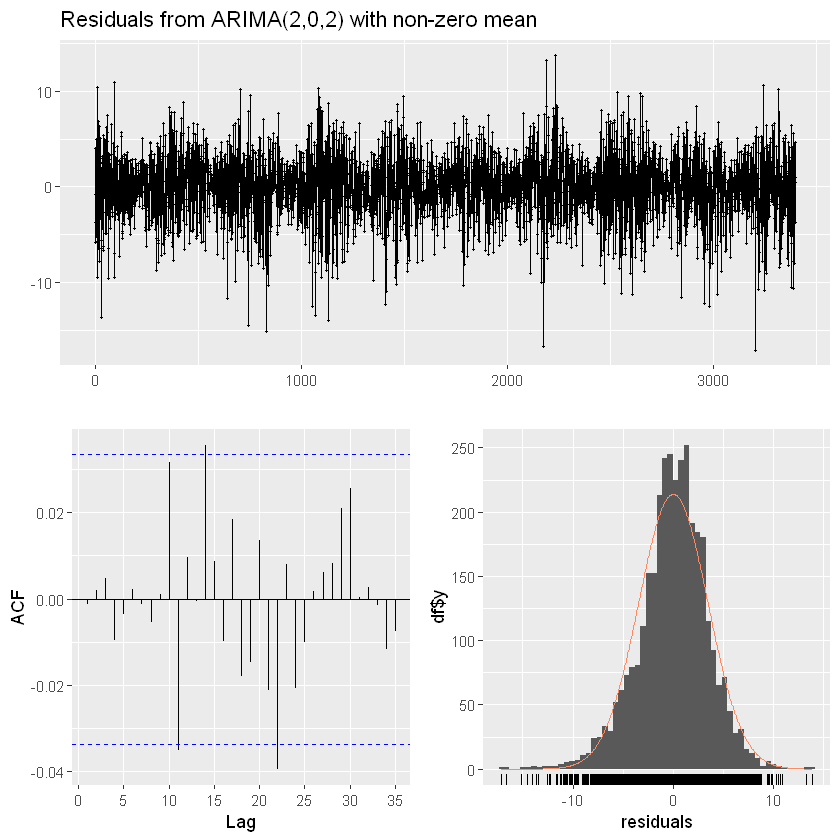

In [97]:
checkresiduals(model)

In [98]:
ei <- residuals(model)

In [99]:
mean(ei)

[1] 0.002294932

In [100]:
var(ei)

[1] 11.88017

In [101]:
var_vec <- vector()
k <- 1
for(i in linspace(300,3100,10)){
    var_vec[k] <- var.test(ei[1:i], ei[i+1:3401], conf.level = 0.95)$p.value
    k <- k+1
}

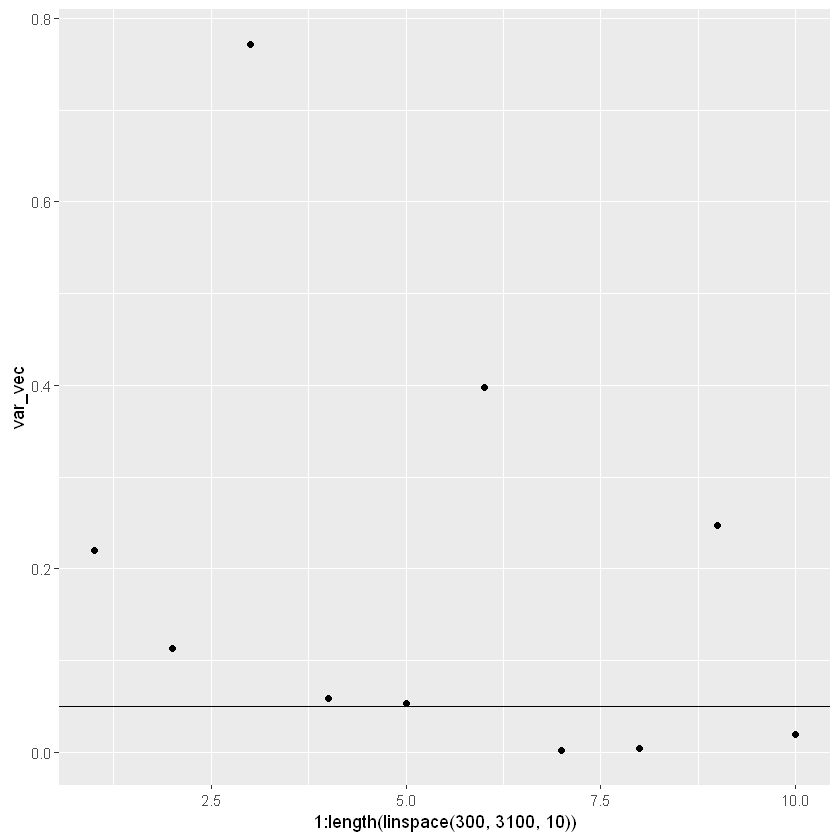

In [102]:
ggplot(mapping=aes(x=1:length(linspace(300,3100,10)),y=var_vec))+geom_point()+geom_hline(aes(yintercept=0.05))

In [103]:
Box.test(ei, type = "Ljung")


	Box-Ljung test

data:  ei
X-squared = 0.0056706, df = 1, p-value = 0.94


In [105]:
arch.test(ei, lag.max=1)


	Box-Ljung test

data:  y^2
X-squared = 53.217, df = 1, p-value = 2.986e-13
alternative hypothesis: y is heteroscedastic
